# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Мне нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

### Содержание

##### 1.Подготовка данных:
* [1.1 Откытие файлов и их изучение.](#1-bullet)
* [1.2 Проверка, что эффективность обогащения рассчитана правильно. Вычисление её на обучающей выборке для признака rougher.output.recovery. Нахождение MAE между расчётами и значением признака.](#2-bullet)
* [1.3 Анализ признаков недоступных в тестовой выборке.](#3-bullet)

##### Часть 2. Анализ данных:
* [2.1 Как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.](#4-bullet)
* [2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках.](#5-bullet)
* [2.3 Исследование суммарной концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.](#6-bullet)
    
##### Часть 3. Построение модели:
* [3.1 Функция для вычисления итоговой sMAPE.](#7-bullet)
* [3.2 Лучшая модель](#8-bullet)



# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import matplotlib

In [2]:
data_train = pd.read_csv('/datasets/gold_recovery_train.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
data_test.isna().sum()

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


In [4]:
# узнаем тип значения  
data_train.info() 
data_test.info()
data_full.info()


# удаление и замена nan 
mean_values = data_train.mean() 

data_train.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace = True)
data_train = data_train.fillna(mean_values)

data_full.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace = True)
data_full = data_full.fillna(mean_values)

data_test = data_test.fillna(mean_values) ### лишнее

data_test_new = data_test.merge(data_full[['date', 'rougher.output.recovery', 'final.output.recovery']], how='left', on='date')
data_test_new.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace = True) 
data_test_new = data_test_new.fillna(mean_values) 

# удаление дат
data_train = data_train.drop('date', axis=1)
data_test = data_test.drop('date', axis=1) 
data_full = data_full.drop('date', axis=1) 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [5]:
data_test.isna().sum()

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

<a id="1-bullet"></a>
**Удалил nan в целевых признаках. В остальных колонках заменил значение на среднее и удалил столбец с датами. С ним не получиться оучить модель.** 

In [6]:
F = data_train['rougher.input.feed_au']
C = data_train['rougher.output.concentrate_au']
T = data_train['rougher.output.tail_au']

In [7]:
data_train['recovery'] = ((C * (F - T)) / (F * (C - T)))*100
data_train = data_train.dropna().reset_index(drop=True)

In [8]:
data_train[['rougher.output.recovery','recovery']].head(10)

,rougher.output.recovery,recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
5,88.156912,88.156912
6,88.168065,88.168065
7,87.668336,87.668336
8,87.035862,87.035862
9,87.650868,87.650868


<a id="2-bullet"></a>
**значения отличаются. В меньшую сторону**

In [9]:
mean_absolute_error(data_train['rougher.output.recovery'], data_train['recovery'])

9.46896498277233e-15

В среднем мы ошибаемся на 0.0000000000000095 когда находим эффективность обогащения. Мне кажется это очень незначительная погрешность

**По результатам наша найденная переменная не очень хороша. Как-то модель очень плохо по ней учиться**

In [10]:
set(list(data_train))
set(list(data_test))
set(list(data_train)) - set(list(data_test))


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'recovery',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'roug

In [11]:
features = data_train[data_test.columns]

<a id="3-bullet"></a>

В тестовой выборке нет финальных результатов
- output — параметры продукта
- calculation — расчётные характеристики
- **Я так понимаю этих признаков нет потому что они нужны только для обучения**

# 2. Анализ данных

In [12]:
data_full['input'] = 100 - (data_full['rougher.input.feed_au'] + data_full['rougher.input.feed_ag'] + data_full['rougher.input.feed_pb'] + data_full['rougher.input.feed_sol'])
data_full['rougher_output'] = 100 - (data_full['rougher.output.concentrate_au'] + data_full['rougher.output.concentrate_ag']+ data_full['rougher.output.concentrate_pb']+ data_full['rougher.output.concentrate_sol'])
data_full['final_output'] = 100 -(data_full['final.output.concentrate_au'] + data_full['final.output.concentrate_ag'] + data_full['final.output.concentrate_pb']+ data_full['final.output.concentrate_sol'])

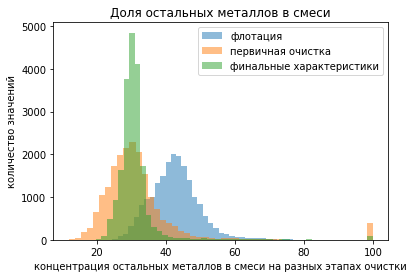

In [13]:
plt.xlabel('концентрация остальных металлов в смеси на разных этапах очистки')
plt.ylabel('количество значений')
plt.title('Доля остальных металлов в смеси')

x = data_full['input']
y = data_full['rougher_output']
a = data_full['final_output']         


plt.hist(x, bins=50, alpha=0.5, label='флотация')
plt.hist(y, bins=50, alpha=0.5, label='первичная очистка')
plt.hist(a, bins=50, alpha=0.5, label='финальные характеристики')
plt.legend(loc='upper right')
plt.show()

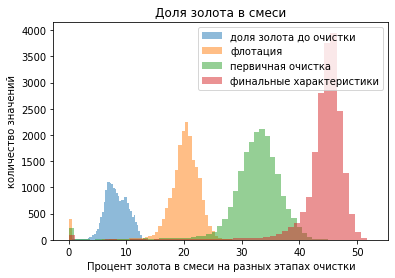

In [14]:
plt.xlabel('Процент золота в смеси на разных этапах очистки')
plt.ylabel('количество значений')
plt.title('Доля золота в смеси')

x = data_full['rougher.output.concentrate_au']
y = data_full['primary_cleaner.output.concentrate_au']
a = data_full['final.output.concentrate_au']            
b = data_full['rougher.input.feed_au']

plt.hist(b, bins=50, alpha=0.5, label='доля золота до очистки')
plt.hist(x, bins=50, alpha=0.5, label='флотация')
plt.hist(y, bins=50, alpha=0.5, label='первичная очистка')
plt.hist(a, bins=50, alpha=0.5, label='финальные характеристики')
plt.legend(loc='upper right')
plt.show()


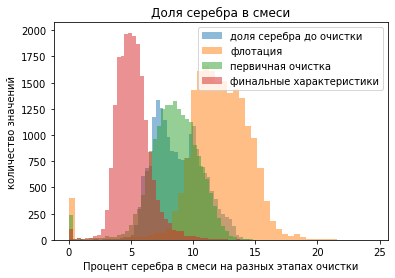

In [15]:
plt.xlabel('Процент серебра в смеси на разных этапах очистки')
plt.ylabel('количество значений')
plt.title('Доля серебра в смеси')
x = data_full['rougher.output.concentrate_ag']
y = data_full['primary_cleaner.output.concentrate_ag']
a = data_full['final.output.concentrate_ag'] 
b = data_full['rougher.input.feed_ag']

plt.hist(b, bins=50, alpha=0.5, label='доля серебра до очистки')
plt.hist(x, bins=50, alpha=0.5, label='флотация')
plt.hist(y, bins=50, alpha=0.5, label='первичная очистка')
plt.hist(a, bins=50, alpha=0.5, label='финальные характеристики')
plt.legend(loc='upper right')
plt.show()

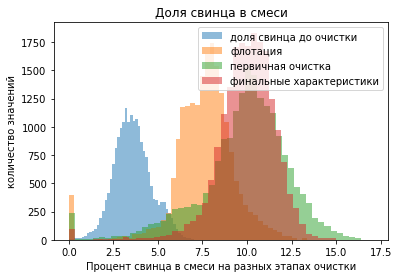

In [16]:
plt.xlabel('Процент свинца в смеси на разных этапах очистки')
plt.ylabel('количество значений')
plt.title('Доля свинца в смеси')
x = data_full['rougher.output.concentrate_pb']
y = data_full['primary_cleaner.output.concentrate_pb']
a = data_full['final.output.concentrate_pb']    
b = data_full['rougher.input.feed_pb']

plt.hist(b, bins=50, alpha=0.5, label='доля свинца до очистки')
plt.hist(x, bins=50, alpha=0.5, label='флотация')
plt.hist(y, bins=50, alpha=0.5, label='первичная очистка')
plt.hist(a, bins=50, alpha=0.5, label='финальные характеристики')
plt.legend(loc='upper right')
plt.show()

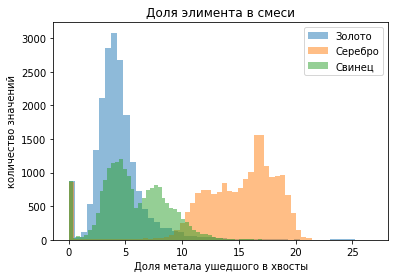

In [17]:
plt.xlabel('Доля метала ушедшого в хвосты')
plt.ylabel('количество значений')
plt.title('Доля элимента в смеси')
x = data_full['secondary_cleaner.output.tail_au']
y = data_full['secondary_cleaner.output.tail_ag']
a = data_full['secondary_cleaner.output.tail_pb']   


plt.hist(x, bins=50, alpha=0.5, label='Золото')
plt.hist(y, bins=50, alpha=0.5, label='Серебро')
plt.hist(a, bins=50, alpha=0.5, label='Свинец')
plt.legend(loc='upper right')
plt.show()

<a id="4-bullet"></a>

**На каждом из графиков видно, что очистка работает. И в хвостах довольоо мало золота. Хотя консентрация свинца не сильно меняется. Мне кажется с его фильтрацией точно есть проблемы. Хотя это может быть сделано что-бы утежелить золото**

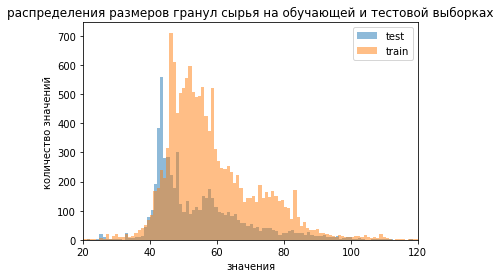

In [18]:
plt.xlabel('значения')
plt.ylabel('количество значений')
plt.title('распределения размеров гранул сырья на обучающей и тестовой выборках')
x = data_test['rougher.input.feed_size']
y = data_train['rougher.input.feed_size']


plt.hist(x, bins=500, alpha=0.5, label='test')
plt.hist(y, bins=500, alpha=0.5, label='train')
plt.legend(loc='upper right')
plt.xlim(20, 120)
plt.show()

(20, 120)

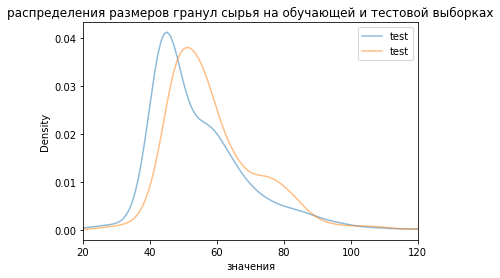

In [19]:
#matplotlib.style.use('ggplot')

plt.xlabel('значения')
plt.ylabel('количество значений')
plt.title('распределения размеров гранул сырья на обучающей и тестовой выборках')

x = data_test['rougher.input.feed_size']
y = data_train['rougher.input.feed_size']

x.plot.kde(alpha=0.5, label='test')
y.plot.kde(alpha=0.5, label='test')
plt.legend(loc='upper right')
plt.xlim(20, 120)

<a id="5-bullet"></a>

**Распределения отличаются друг от друга, но не сильно. Оценка модели будет правильной**

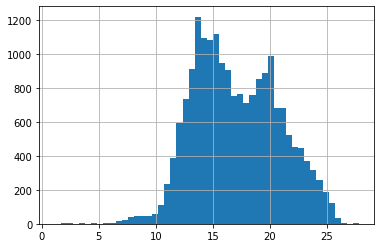

In [20]:
data_full['input_feed'] = data_full['rougher.input.feed_au'] + data_full['rougher.input.feed_ag']
+ data_full['rougher.input.feed_pb'] + data_full['rougher.input.feed_sol']
data_full = data_full.query('input_feed >= 0.1')
data_full['input_feed'].hist(bins=50) # Гистограмма всей таблицы
plt.show()

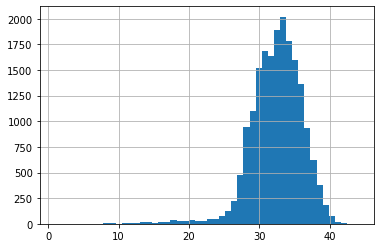

In [21]:
data_full['all_rougher'] = data_full['rougher.output.concentrate_au'] + data_full['rougher.output.concentrate_ag'] 
+ data_full['rougher.output.concentrate_pb'] + data_full['rougher.output.concentrate_sol']
data_full = data_full.query('all_rougher >= 0.1')
data_full['all_rougher'].hist(bins=50) # Гистограмма всей таблицы
plt.show()

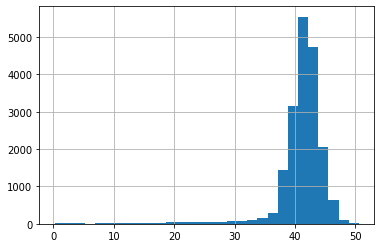

In [22]:
data_full['all_primary_cleaner'] = data_full['primary_cleaner.output.concentrate_au'] + data_full['primary_cleaner.output.concentrate_ag']
+ data_full['primary_cleaner.output.concentrate_pb'] + data_full['primary_cleaner.output.concentrate_sol']
data_full = data_full.query('all_primary_cleaner >= 0.1')
data_full['all_primary_cleaner'].hist(bins=30) # Гистограмма всей таблицы
plt.show()

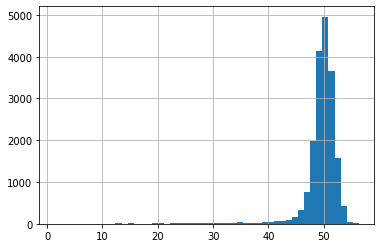

In [23]:
data_full['all_final_cleaner'] = data_full['final.output.concentrate_au'] + data_full['final.output.concentrate_ag']
+ data_full['final.output.concentrate_pb'] + data_full['final.output.concentrate_sol']
data_full = data_full.query('all_final_cleaner >= 0.1')
data_full['all_final_cleaner'].hist(bins=50) # Гистограмма всей таблицы
plt.show()

In [24]:
def dov_int(sample):

    print("Cреднее:", sample.mean())

    # 95%-й доверительный интервал для среднего чека мармелада
    # распределение Стьюдента scipy.stats.t
    # функция для доверительного интервала interval()
    confidence_interval = st.t.interval( 
        0.95, len(sample)-1,sample.mean(), sample.sem()) 

    print("95%-ый доверительный интервал:", confidence_interval)

In [25]:
print('флотация', dov_int(data_full['all_rougher']))
print('первичная очистка', dov_int(data_full['all_primary_cleaner']))
print('финальные характеристики', dov_int(data_full['all_final_cleaner']))


Cреднее: 32.444250508311974
95%-ый доверительный интервал: (32.392276951926654, 32.496224064697294)
флотация None
Cреднее: 41.03491695527976
95%-ый доверительный интервал: (40.972395762086485, 41.09743814847304)
первичная очистка None
Cреднее: 49.49708476880612
95%-ый доверительный интервал: (49.44265581801901, 49.551513719593224)
финальные характеристики None


<a id="6-bullet"></a>

**Тут не мало около нулевых выбросов, но удалять мне кажется их будет на правильным. Они встречаются довольно часто, может просто было маленькая консентрация веществ. Вот нулевые значения можно удалить. Раз тех элементов которые нам нужны там все равно нет.**

In [26]:
data_train = data_train[data_train['rougher.output.concentrate_au'] + data_train['rougher.output.concentrate_ag'] 
+ data_train['rougher.output.concentrate_pb'] + data_train['rougher.output.concentrate_sol'] >= 0.1]

data_train = data_train[data_train['rougher.input.feed_au'] + data_train['rougher.input.feed_ag'] 
+ data_train['rougher.input.feed_pb'] + data_train['rougher.input.feed_sol'] >= 0.1]

data_train = data_train[data_train['primary_cleaner.output.concentrate_au'] + data_train['primary_cleaner.output.concentrate_ag'] 
+ data_train['primary_cleaner.output.concentrate_pb'] + data_train['primary_cleaner.output.concentrate_sol'] >= 0.1]

data_train = data_train[data_train['final.output.concentrate_au'] + data_train['final.output.concentrate_ag'] 
+ data_train['final.output.concentrate_pb'] + data_train['final.output.concentrate_sol'] >= 0.1]
features = data_train[data_test.columns]

# 3. Модель

In [27]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

<a id="7-bullet"></a>
**sMAPE**

In [28]:
target_rougher = data_train['rougher.output.recovery']
target_final = data_train['final.output.recovery']
features = data_train[data_test.columns]
 
def smape_final(smape_1, smape_2):
    return smape_1 * 0.25 + smape_2 * 0.75
 
model_rougher = LinearRegression()
score_rougher = (cross_val_score(model_rougher, features, target_rougher, cv = 5, scoring = make_scorer(smape, greater_is_better=False)) * -1)
final_score_rougher = score_rougher.mean()
print(final_score_rougher)
print(score_rougher)
 
model_final = LinearRegression()
score_final = (cross_val_score(model_final, features, target_final, cv = 5, scoring = make_scorer(smape, greater_is_better=False)) * -1)
final_score_final = score_final.mean()
print(final_score_final)
print(score_final)
 
print('\nfinal sMAPE on LinearRegression =', smape_final(final_score_rougher, final_score_final))

7.223139842860681
[8.78236402 7.07157641 6.16535149 4.97680286 9.11960443]
11.281386161524988
[13.32279336 10.29123766 10.36288788  9.16519206 13.26481984]

final sMAPE on LinearRegression = 10.266824581858911


In [29]:
target_rougher = data_train['rougher.output.recovery']
target_final = data_train['final.output.recovery']


 
best_mae = 100
for depth in range(1, 6, 1): 
    model_rougher = RandomForestRegressor(n_estimators=1, max_depth=depth, random_state=12345)
    score_rougher = (cross_val_score(model_rougher, features, target_rougher, cv = 5, scoring = make_scorer(smape, greater_is_better=False)) * -1)
    final_score_rougher = score_rougher.mean()
    print(final_score_final)
    print(score_final)
    for dep in range(1, 6, 1):
        model_final = RandomForestRegressor(n_estimators=1, max_depth=dep, random_state=12345)
        score_final = (cross_val_score(model_final, features, target_final, cv = 5, scoring = make_scorer(smape, greater_is_better=False)) * -1)
        final_score_final = score_final.mean()
        print(final_score_final)
        print(score_final)

        mae = smape_final(final_score_rougher, final_score_final)
        print('MAE', mae)
        if mae < best_mae:
            best_mae = mae
            best_model_1 = model_rougher
            best_model_2 = model_final
print(best_mae, '\n', best_model_1,'\n',  best_model_2)

11.281386161524988
[13.32279336 10.29123766 10.36288788  9.16519206 13.26481984]
9.434991667756268
[ 9.59172037  8.07868754  8.93803451  9.58113505 10.98538087]
MAE 9.041244079435483
9.698946810069568
[ 9.6226955   7.82218241 11.28817066  9.07950051 10.68218498]
MAE 9.239210436170456
9.577351639484975
[ 9.73726807  8.12973732 11.26538759  8.41829758 10.33606764]
MAE 9.148014058232013
10.382049579650138
[10.92595306  9.66628526 11.51819172  8.30734552 11.49247234]
MAE 9.751537513355885
11.300879793471342
[11.228283   14.22846969 10.16194319  8.98925966 11.89644343]
MAE 10.440660173721788
11.300879793471342
[11.228283   14.22846969 10.16194319  8.98925966 11.89644343]
9.434991667756268
[ 9.59172037  8.07868754  8.93803451  9.58113505 10.98538087]
MAE 9.005423233265788
9.698946810069568
[ 9.6226955   7.82218241 11.28817066  9.07950051 10.68218498]
MAE 9.203389590000763
9.577351639484975
[ 9.73726807  8.12973732 11.26538759  8.41829758 10.33606764]
MAE 9.112193212062317
10.382049579650138


In [30]:
target_rougher = data_train['rougher.output.recovery']
target_final = data_train['final.output.recovery']

 
model_rougher = RandomForestRegressor(n_estimators=100, max_depth=3 , random_state=12345)
score_rougher = (cross_val_score(model_rougher, features, target_rougher, cv = 5, scoring = make_scorer(smape, greater_is_better=False)) * -1)
final_score_rougher = score_rougher.mean()
print(final_score_rougher)
print(score_rougher)
 
model_final = RandomForestRegressor(n_estimators=100, max_depth=1 , random_state=12345)
score_final = (cross_val_score(model_final, features, target_final, cv = 5, scoring = make_scorer(smape, greater_is_better=False)) * -1)
final_score_final = score_final.mean()
print(final_score_final)
print(score_final)
 
print('\nfinal sMAPE on RandomForestRegressor =', smape_final(final_score_rougher, final_score_final))

6.631873577134662
[8.20002061 6.77364429 4.72682477 5.5056193  7.95325892]
9.499072940596587
[ 9.571602    8.06427217  8.8543359  10.02977844 10.97537619]

final sMAPE on RandomForestRegressor = 8.782273099731107


- final sMAPE on LinearRegression = 10.274257973543078
- final sMAPE on Tree = 8.930007865615474
- final sMAPE on RandomForestRegressor = 8.782195665708613
- **Лучшая модель это Случайный лес "RandomForestRegressor"**

In [31]:
target_rougher = data_train['rougher.output.recovery']
target_final = data_train['final.output.recovery']
features = data_train[data_test.columns]

features_valid = data_test_new[data_test.columns]
target_valid_rougher = data_test_new['rougher.output.recovery']
target_valid_final = data_test_new['final.output.recovery']

model_rougher = RandomForestRegressor(n_estimators=100, max_depth=3 , random_state=12345)
model_rougher.fit(features, target_rougher)
predicted_rougher = model_rougher.predict(features_valid)

model_final = RandomForestRegressor(n_estimators=100, max_depth=1 , random_state=12345)
model_final.fit(features, target_final)
predicted_final = model_final.predict(features_valid)

mae = smape_final(smape(target_valid_rougher, predicted_rougher), smape(target_valid_final, predicted_final))

print('\nfinal sMAPE on RandomForestRegressor on Test_data =', mae)


final sMAPE on RandomForestRegressor on Test_data = 9.271511624625838


**final sMAPE on RandomForestRegressor on Test_data = 8.996984836760245**

In [32]:
# целевой столбец обучающей выборки
target_rougher = data_train['rougher.output.recovery']
target_final = data_train['final.output.recovery']

# вектор предсказаний константной модели для объектов тестовой выборки
predicted_rougher = pd.Series(target_rougher.median(), index=target_valid_rougher.index)
predicted_final = pd.Series(target_final.median(), index=target_valid_final.index)

# sMAPE константной модели 
smape_1 = smape(target_valid_rougher, predicted_rougher)
smape_2 = smape(target_valid_final, predicted_final) 
print('final sMAPE on Median =', smape_final(smape_1, smape_2))

final sMAPE on Median = 9.450339967140751


***Модель предсказывает похожий результат. Различие очень мало. Модель адекватна, но получается результат чуть лучше, чем с медианой.***

<a id="8-bullet"></a>

#  4. Вывод
**Что делать с свинцом непонятно, его концентрация после очистки почти не падает. Мне кажется не нормальным. Есть небольшая погрешность между расчетами и значением признака rougher.output.recovery. Распределение на обучающей и тестовой выборках отличаются не сильно. В выборках есть очень маленькие значения. Это связано с маленькой концентрацией веществ. Эти значения я удалил. Лучшая модель это RandomForestRegressor. Модель адекватна. Но мне кажется, что наша модель не сильно поможет. Потому что мы получаем результат лучше, чем, когда берем медиану.**